## Talk to an EBM about the Spacetime Titanic
#### https://www.kaggle.com/competitions/spaceship-titanic

In [1]:
import pandas as pd
import textwrap
from sklearn.model_selection import train_test_split

import openai
import guidance
import os

from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

import t2ebm

# auto-reload
%load_ext autoreload
%autoreload 2

In [2]:
# this notebook works with any LLM supported by guidance. we obtained the best results with GPT-4
openai.organization = ""
openai.api_key = os.environ["OPENAI_API_KEY"]

llm = guidance.llms.OpenAI("gpt-3.5-turbo-16k") # prompts require ~6k tokens

AttributeError: module 'guidance' has no attribute 'llms'

In [20]:
messages = t2ebm.prompts.describe_graph("{the graph}", "{an expert statistician and data scientist}", "{y-axis description (optional)}", "{dataset description (optional)}", "{special task description (optional)}")
print("SYSTEM:", messages[0]["content"])
print("USER:", messages[1]["content"])

SYSTEM: You are {an expert statisticial and data scientist}. You interpret global explanations produced by a generalized additive model (GAM). You answer all questions to the best of your ability, combining the data contained in the graph, any data set description you are given, and your knowledge about the real world.
USER: Below is the graph of a generalized additive model (GAM). The graph is presented as a JSON object with keys representing the x-axis and values representing the y-axis. For continuous features, the keys are intervals that represent ranges where the function predicts the same value. For categorical features, each key represents a possible value that the feature can take.
    
The graph is provided in the following format:
    - The name of the feature depicted in the graph
    - The type of the feature (continuous, categorical, or boolean)
    - Mean values
    - Lower bounds of confidence interval (optional)
    - Upper bounds of confidence interval (optional)

{y-a

### Load the titanic dataset and train an EBM

In [7]:
df = pd.read_csv("../data/spaceship-titanic-train.csv") # replace with path to dataset on your machine
df.head()

# transform cabin since 8000 unique values do not fit into the context windows of the LLM we want to use
df['Cabin'] = df['Cabin'].map(lambda x: x[:1] + '/' + x[-1] if isinstance(x, str) else x)

# pandas to numpy array
X_data = df.drop(columns=["PassengerId", "Transported", "Name"]).values
y_data = df["Transported"].values

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [8]:
feature_names = df.drop(columns=["PassengerId", "Transported", "Name"]).columns.tolist()

ebm = ExplainableBoostingClassifier(interactions=0, 
                                    feature_names=feature_names)

ebm.fit(X_train, y_train)
ebm.score(X_test, y_test)

/anaconda/envs/t2ebm_dev/lib/python3.8/site-packages/interpret/glassbox/_ebm/_ebm.py:666: UserWarning:

Missing values detected. Our visualizations do not currently display missing values. To retain the glassbox nature of the model you need to either set the missing values to an extreme value like -1000 that will be visible on the graphs, or manually examine the missing value score in ebm.term_scores_[term_index][0]



0.7889591719378953

In [5]:
show(ebm.explain_global()) # visualize the EBM

### High-Level API: Directly pass the EBM to the LLM

##### Getting the LLM to describe a graph from the model is as simple as this

In [6]:
graph_description = t2ebm.llm_describe_ebm_graph(llm, ebm, 0) # feature 0, 'HomePlanet'
print(textwrap.fill(graph_description, 80))

The feature "HomePlanet" has a significant influence on the outcome variable.
The mean values for each category indicate that individuals from "Europa" have
the strongest positive effect, followed by individuals from "Mars" with a
slightly positive effect. On the other hand, individuals from "Earth" have a
negative effect on the outcome. These effects are consistent with our
expectations, as "Europa" and "Mars" are likely associated with factors that
contribute positively to the outcome, while "Earth" may have characteristics
that negatively impact the outcome. However, it's important to consider the
uncertainty in these estimates, as indicated by the confidence intervals.
Overall, the "HomePlanet" feature plays a significant role in determining the
outcome, with individuals from different planets having varying effects.


In [7]:
graph_description = t2ebm.llm_describe_ebm_graph(llm, ebm, 9) # feature 9, 'Spa'
print(textwrap.fill(graph_description, 80))

INFO: The graph of feature Spa was simplified by 0.5%.


The "Spa" feature has a significant influence on the outcome, as demonstrated by
the non-linear pattern observed in the graph. The predicted values of the
outcome initially start high for lower values of the "Spa" feature, then rapidly
decrease before stabilizing at a lower value. This suggests that the presence or
absence of a spa has a substantial impact on the outcome. However, there are
regions in the graph where the relationship between the "Spa" feature and the
outcome is surprising or counterintuitive, indicating the influence of other
factors or interactions. Therefore, while the "Spa" feature is influential, it
is important to consider other variables and potential interactions to fully
understand its impact on the outcome.


##### We can give the LLM more context by providing a description of the dataset and the outcome

In [8]:
dataset_description = """Hi there, here is a general description of the data set on which I trained the model. This description is from kaggle:

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

The task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.

Feature Descriptions:

PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
Destination - The planet the passenger will be debarking to.
Age - The age of the passenger.
VIP - Whether the passenger has paid for special VIP service during the voyage.
RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
Name - The first and last names of the passenger.
"""

y_axis_description = "The y-axis depicts contributions in log-odds towards the outcome, that is the probability that the passenger was transported to another dimension."

In [9]:
graph_description = t2ebm.llm_describe_ebm_graph(llm, 
                                                 ebm,
                                                 0, 
                                                 dataset_description=dataset_description, 
                                                 y_axis_description=y_axis_description)
print(textwrap.fill(graph_description, 80))

The HomePlanet feature has a significant influence on the probability of
passengers being transported to an alternate dimension during the collision with
the spacetime anomaly. Passengers from Earth have a negative effect, indicating
a lower likelihood of being transported compared to the reference category. On
the other hand, passengers from Europa have a positive effect, suggesting a
higher likelihood of being transported. Passengers from Mars also have a
positive effect, but to a lesser extent than passengers from Europa. These
findings are surprising as one might expect passengers from Earth to have a
higher probability of being transported, considering their proximity to the
spaceship's departure point. However, it is possible that passengers from Earth
were more prepared or took precautions to minimize their chances of being
transported. Further investigation is required to fully understand the reasons
behind these patterns.


In [10]:
graph_description = t2ebm.llm_describe_ebm_graph(llm, 
                                                 ebm,
                                                 9, 
                                                 dataset_description=dataset_description, 
                                                 y_axis_description=y_axis_description)
print(textwrap.fill(graph_description, 80))

INFO: The graph of feature Spa was simplified by 0.5%.


The feature "Spa" has a non-linear influence on the probability of being
transported to an alternate dimension during the collision with the spacetime
anomaly. The graph shows that as the amount billed at the Spa increases, the
predicted probability initially decreases, reaches a minimum value, and then
starts increasing again. This suggests that there might be an optimal range of
spending at the Spa associated with a higher probability of not being
transported. However, beyond this optimal range, further increase in spending at
the Spa is associated with a higher probability of being transported. This non-
linear relationship indicates that the influence of the Spa feature on the
outcome is complex and may depend on various other factors and interactions
within the dataset.


##### We can also ask the LLM to summarize the entire model

In [11]:
model_description = t2ebm.llm_describe_ebm(llm, 
                                           ebm,
                                           dataset_description=dataset_description, 
                                           y_axis_description=y_axis_description) # by default this creates a 30 sentence summary
print(textwrap.fill(model_description, 80))

INFO: The graph of feature RoomService was simplified by 1.1%.


INFO: The graph of feature FoodCourt was simplified by 0.4%.
INFO: The graph of feature ShoppingMall was simplified by 0.5%.
INFO: The graph of feature Spa was simplified by 0.5%.
INFO: The graph of feature VRDeck was simplified by 0.5%.
The Generalized Additive Model (GAM) for predicting whether a passenger was
transported to an alternate dimension during the collision with the spacetime
anomaly on the Spaceship Titanic reveals the following key findings:  1. The
most important features in the model are Spa, VRDeck, CryoSleep, RoomService,
and HomePlanet. 2. Spa spending has a significant influence, with an optimal
range associated with a higher probability of not being transported. 3. VRDeck
spending also plays a significant role, with an abrupt reversal in the effect at
a certain threshold. 4. Passengers in cryosleep had a higher probability of
being transported, suggesting their vulnerability to the anomaly. 5. Moderate
spending on room service is associated with a lower probabilit

### Low-Level API: Extract Graphs from EBMs and perform custom prompts

In [5]:
import t2ebm.graphs as graphs

##### We have a simple datastructure for graphs, and some operations on them

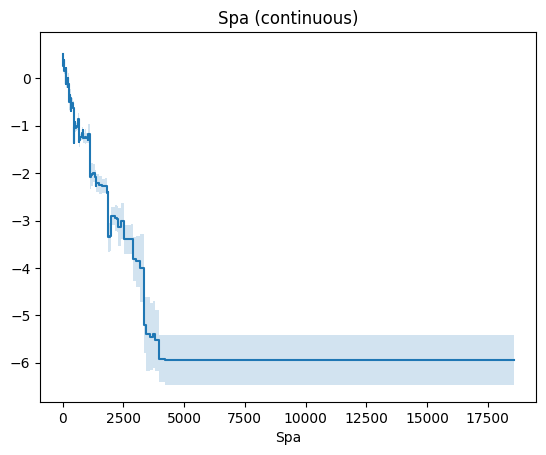

In [13]:
graph = graphs.extract_graph(ebm, 9)
graphs.plot_graph(graph)

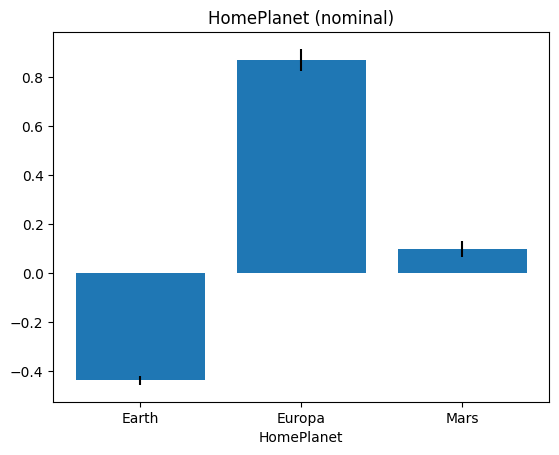

In [14]:
graphs.plot_graph(graphs.extract_graph(ebm, 0))

##### We can simplify graphs to reduce the number of tokens. There is a parameter to control the degree of simplification.

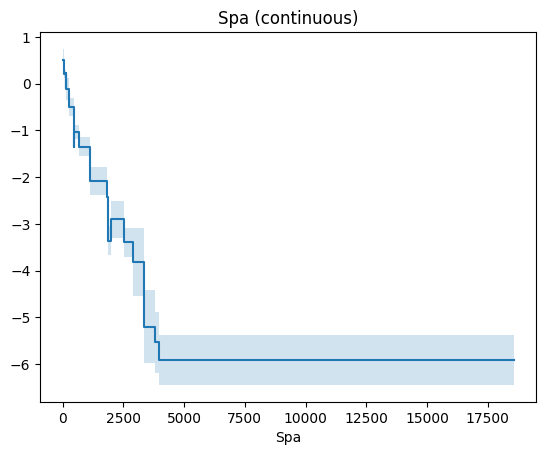

In [15]:
t2ebm.graphs.plot_graph(t2ebm.graphs.simplify_graph(graph, min_variation_per_cent=0.041))

##### We have to convert graphs to text before passing them to the LLM

In [16]:
graph_as_text = graphs.graph_to_text(graph, max_tokens=1000)
print(graph_as_text)

INFO: The graph of feature Spa was simplified by 4.1%.
This graph represents a continuous-valued feature. The keys are intervals that represent ranges where the function predicts the same value.

Feature Name: Spa
Feature Type: continuous
Means: {"(0.0, 36.5)": 0.517, "(36.5, 117.5)": 0.212, "(117.5, 125.5)": -0.091, "(125.5, 130.5)": 0.223, "(130.5, 266.5)": -0.11, "(266.5, 451.0)": -0.497, "(451.0, 460.5)": -0.89, "(460.5, 479.5)": -1.363, "(479.5, 659.5)": -1.032, "(659.5, 1103.5)": -1.347, "(1103.5, 1808.0)": -2.076, "(1808.0, 1870.5)": -2.416, "(1870.5, 1986.5)": -3.358, "(1986.5, 2507.0)": -2.9, "(2507.0, 2905.5)": -3.398, "(2905.5, 3334.5)": -3.817, "(3334.5, 3819.0)": -5.203, "(3819.0, 3978.0)": -5.532, "(3978.0, 18572.0)": -5.917}
Lower Bounds (95%-Confidence Interval): {"(0.0, 36.5)": 0.068, "(36.5, 117.5)": 0.049, "(117.5, 125.5)": -0.434, "(125.5, 130.5)": -0.289, "(130.5, 266.5)": -0.562, "(266.5, 451.0)": -0.884, "(451.0, 460.5)": -1.35, "(460.5, 479.5)": -1.8, "(479.5, 6

In [9]:
graph_as_text = graphs.graph_to_text(graphs.extract_graph(ebm, 0))
print(graph_as_text)

This graph represents categorical feature. Each key represents a possible value that the feature can take.

Feature Name: HomePlanet
Feature Type: categorical
Means: {"Earth": -0.439, "Europa": 0.87, "Mars": 0.098}
Lower Bounds (95%-Confidence Interval): {"Earth": -0.475, "Europa": 0.783, "Mars": 0.034}
Upper Bounds (95%-Confidence Interval): {"Earth": -0.402, "Europa": 0.957, "Mars": 0.162}



#### Given the textual representation of the graph, you can insert it into your own prompts. Often, the first prompt will ask the LLM to describe the graph.

In [10]:
prompt = t2ebm.prompts.describe_graph(graph_as_text,
                                      expert_description="{some kind of expert that will help me.}",
                                      y_axis_description="{The y-axis on the graph depicts how cool the graph is.}",
                                      special_task_description="{Pay special attention to run 'pip install t2ebm'}",
                                      dataset_description="{My dataset is great!}",
                                      include_assistant_response=True)

# our prompts use guidance, and this is a nice way to print them
guidance(prompt, llm=llm)

Stop program {{#system~}} 
You are {some kind of expert that will help me.}
 
You interpret global explanations produced by a generalized additive model (GAM). GAMs produce explanations in the form of graphs that contain the effect of a specific input feature.

The user will first provide a general description of the dataset. Then you will be given graphs from the model, and the user will ask you questions about the graphs. 
 
Answer all questions to the best of your ability, combining both the data contained in the graph, the data set description you were given, and your knowledge about the real world.

Graphs will be presented as a JSON object with keys representing the x-axis and values representing the y-axis. For continuous features, the keys are intervals that represent ranges where the function predicts the same value. For categorical features, each key represents a possible value that the feature can take. {The y-axis on the graph depicts how cool the graph is.} 
 
The user will provide graphs in the following format:
 - The name of the feature depicted in the graph
 - The type of the feature (continuous, categorical, or boolean)
 - Mean values
 - Lower bounds of confidence interval
 - Upper bounds of confidence interval

{Pay special attention to run 'pip install t2ebm'}
 {{~/system}} 

 {{#user~}} 
{My dataset is great!}
 {{~/user}} 

 {{#assistant~}} 
Thanks for this general description of the data set. Please continue and provide more information, for example about the graphs from the model.
 {{~/assistant}} 

 {{#user~}} 
Consider the following graph from the model. This graph represents categorical feature. Each key represents a possible value that the feature can take.

Feature Name: HomePlanet
Feature Type: categorical
Means: {"Earth": -0.439, "Europa": 0.87, "Mars": 0.098}
Lower Bounds (95%-Confidence Interval): {"Earth": -0.475, "Europa": 0.783, "Mars": 0.034}
Upper Bounds (95%-Confidence Interval): {"Earth": -0.402, "Europa": 0.957, "Mars": 0.162}

Please describe the general pattern of the graph.
 {{~/user}} 

 {{#assistant~}} {{gen 'graph_description' temperature=0.7 max_tokens=2000}} {{~/assistant}}